# 今日任务I：朴素贝叶斯与KNN分类性能比较

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from torchvision import transforms
from PIL import Image

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from utils.os import get_root_path

nb_methods = [GaussianNB, MultinomialNB, BernoulliNB, ComplementNB]
# 计算 KNN、NaiveBayes 各类分类器的性能
def evaluate_classifier(X, y, n_neighbors=5):
    # KNN 分类器
    knn = KNN(n_neighbors=n_neighbors)
    knn.fit(X, y)
    y_pred_knn = knn.predict(X)
    # 计算 ACC, NMI, ARI
    acc_knn = np.mean(y_pred_knn == y)
    ari_knn = adjusted_rand_score(y, y_pred_knn)
    nmi_knn = normalized_mutual_info_score(y, y_pred_knn)
    print(f'KNN: ACC={acc_knn:.3f}, ARI={ari_knn:.3f}, NMI={nmi_knn:.3f}')
    
    for nb_method in nb_methods:
        # NaiveBayes 分类器
        gnb = nb_method()
        gnb.fit(X, y)
        y_pred_gnb = gnb.predict(X)
        # 计算 ACC, NMI, ARI
        acc_gnb = np.mean(y_pred_gnb == y)
        ari_gnb = adjusted_rand_score(y, y_pred_gnb)
        nmi_gnb = normalized_mutual_info_score(y, y_pred_gnb)
        print(f'{nb_method.__name__}: ACC={acc_gnb:.3f}, ARI={ari_gnb:.3f}, NMI={nmi_gnb:.3f}')

可视化并计算 Face Images 各类分类器的性能

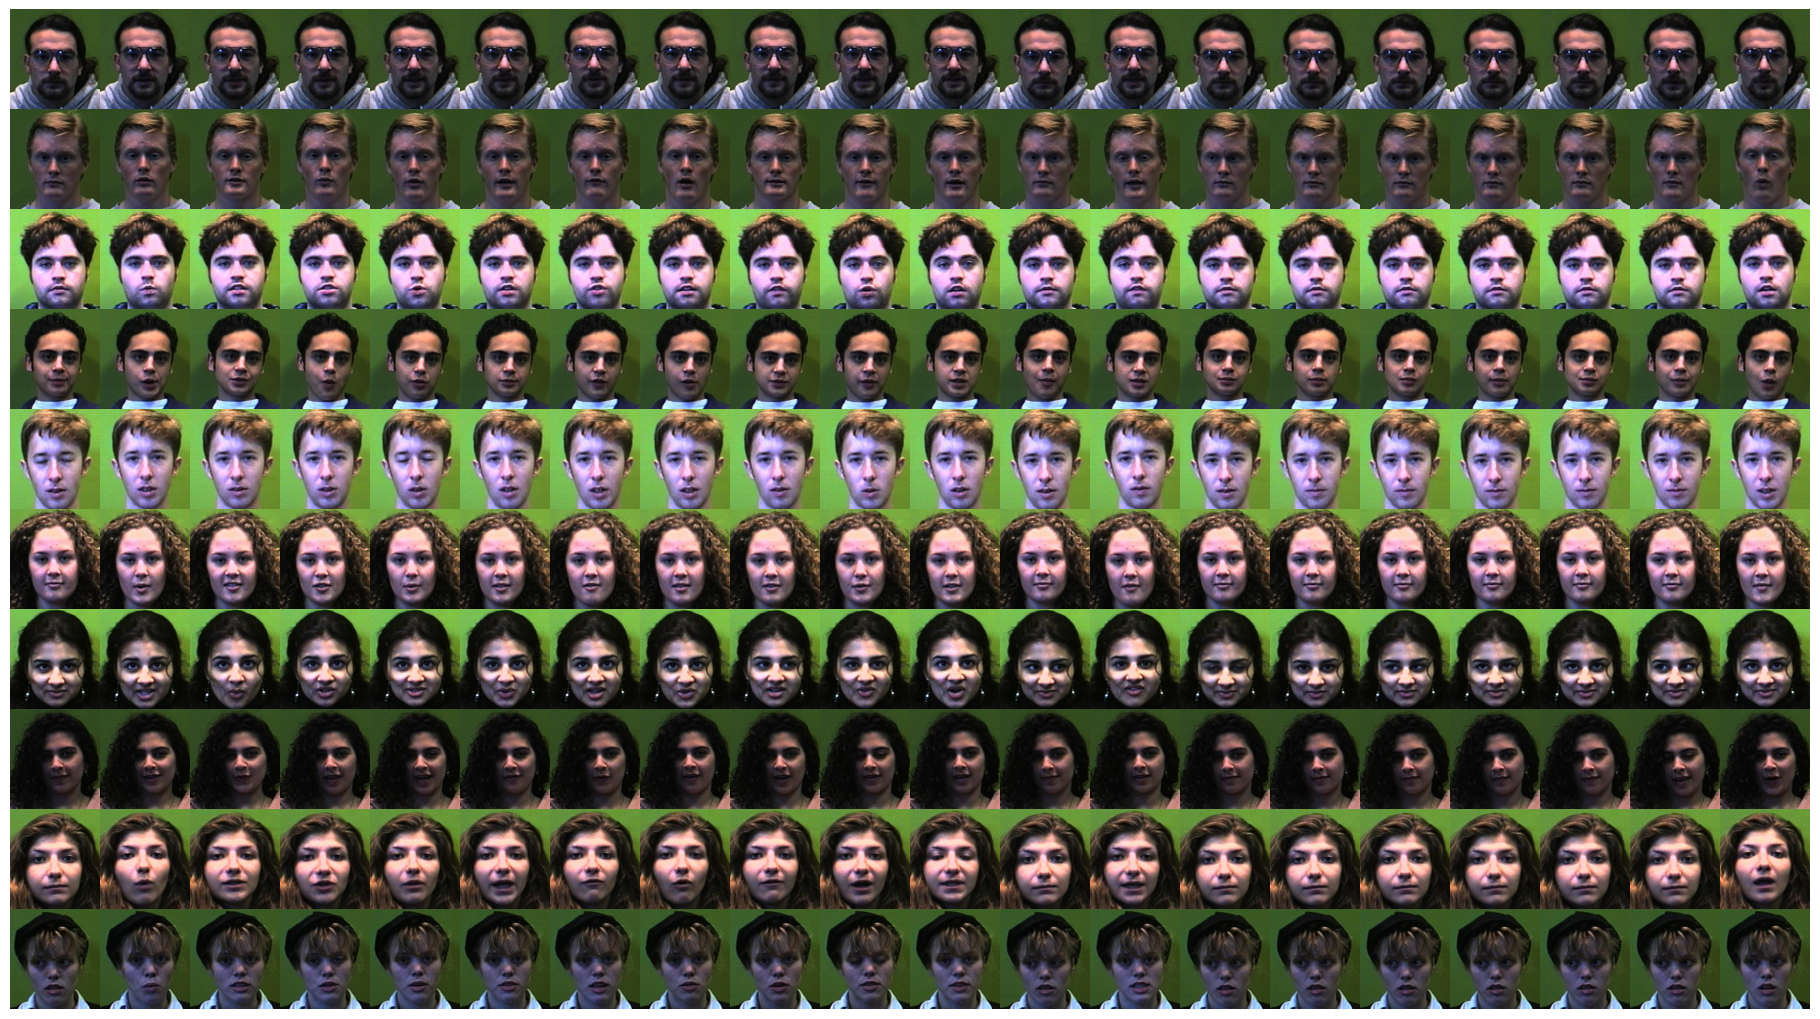

In [12]:
# 文件结构：
# datas/Ch4-data/face_images/
# ├── admars
#     ├── admars.1.jpg
#     ├── ...
#     └── admars.20.jpg
# ├── ahodki
#     ├── ahodki.1.jpg
#     ├── ...
#     └── ahodki.20.jpg
# ├── ...
# └── drbost
#     ├── drbost.1.jpg
#     ├── ...
#     └── drbost.20.jpg
# 其中每个文件下的图片都有 20 张
# 读取并可视化本地路径 datas/Ch4-data/face_images 下所有图片的数据集

# 读取本地路径下的所有图片
image_root = f'{get_root_path()}/datas/Ch4-data/face_images/'
image_dir_list = os.listdir(image_root)
n_faces = len(image_dir_list)  # 人脸种类数
n_clusters = 5

# 获取其中一个图像的大小作为统一的显示大小
# noinspection PyShadowingNames
def get_fig_size(image_root):
    dir_path = os.path.join(image_root, image_dir_list[0])
    image_path = os.path.join(dir_path, os.listdir(dir_path)[0])
    image = cv2.imread(image_path)
    image_size = image.shape[:2]
    fig_size = (20 * image_size[1] / 200, n_faces * image_size[0] / 200)
    return fig_size, image_size
fig_size, image_size = get_fig_size(image_root)

# 显示图片的密集排布形式
face_images = []
face_labels = []
fig, axes = plt.subplots(n_faces, 20, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
for i, image_dir_name in enumerate(image_dir_list):
    image_dir = os.path.join(image_root, image_dir_name)
    image_list = os.listdir(image_dir)
    for j, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 存储图像和标签
        face_images.append(img)
        face_labels.append(i)
        
        # 显示原始图像
        axes[i][j].imshow(img)
        axes[i][j].axis('off')

plt.show()

In [13]:
# 计算 Face Images 各类分类器的性能
X = np.array(face_images).reshape(len(face_images), -1)
y = np.array(face_labels)
evaluate_classifier(X, y)

KNN: ACC=1.000, ARI=1.000, NMI=1.000
GaussianNB: ACC=1.000, ARI=1.000, NMI=1.000
MultinomialNB: ACC=1.000, ARI=1.000, NMI=1.000
BernoulliNB: ACC=0.995, ARI=0.989, NMI=0.991
ComplementNB: ACC=1.000, ARI=1.000, NMI=1.000


可视化并计算 Digits 各类分类器的性能

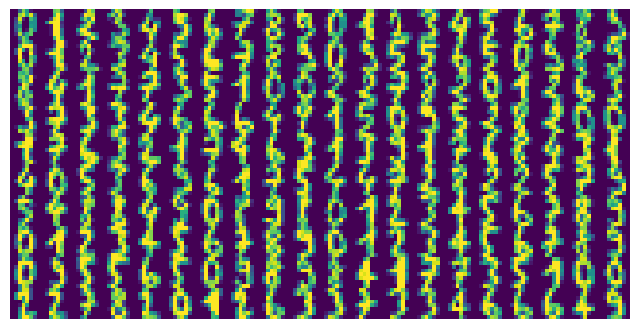

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

# 加载 digits(MNIST) 数据集
n_class = 10
digits = datasets.load_digits(n_class=n_class)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
y = y.astype(int)   # 将标签转换为整数

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

n_cols = 20
n_rows = 10
n_display = n_rows * n_cols

# 字符数据可视化（串串烧方式）
def plot_digits(instances, images_per_row=10):
    size = 8
    
    n_cols = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // n_cols + 1
    n_empty = n_rows * n_cols - len(instances)   # 空白图像数量
    
    # N + n_empty = n_cols * n_rows
    images = [instance.reshape(size, size) for instance in instances]   # [N, 64] -> [N, 8, 8]
    images.append(np.zeros((size, size * n_empty)))
    
    # 图像拼接
    row_images = []
    for row in range(n_rows):
        r_images = images[row * n_cols : (row + 1) * n_cols]
        row_images.append(np.concatenate(r_images, axis=1))
    image = np.concatenate(row_images, axis=0)
    
    # 显示图像
    plt.imshow(image, cmap=plt.colormaps['viridis'])
    plt.axis("off")
    
plt.figure(figsize=(8, 8))
example_images = X[:n_display]
plot_digits(example_images, images_per_row=n_cols)
plt.show()

In [15]:
# 计算 Digits 各类分类器的性能
evaluate_classifier(X_train, y_train)

KNN: ACC=0.990, ARI=0.977, NMI=0.975
GaussianNB: ACC=0.860, ARI=0.719, NMI=0.780
MultinomialNB: ACC=0.911, ARI=0.816, NMI=0.837
BernoulliNB: ACC=0.871, ARI=0.747, NMI=0.769
ComplementNB: ACC=0.814, ARI=0.653, NMI=0.705


可视化并计算 17flowers 各类分类器的性能 

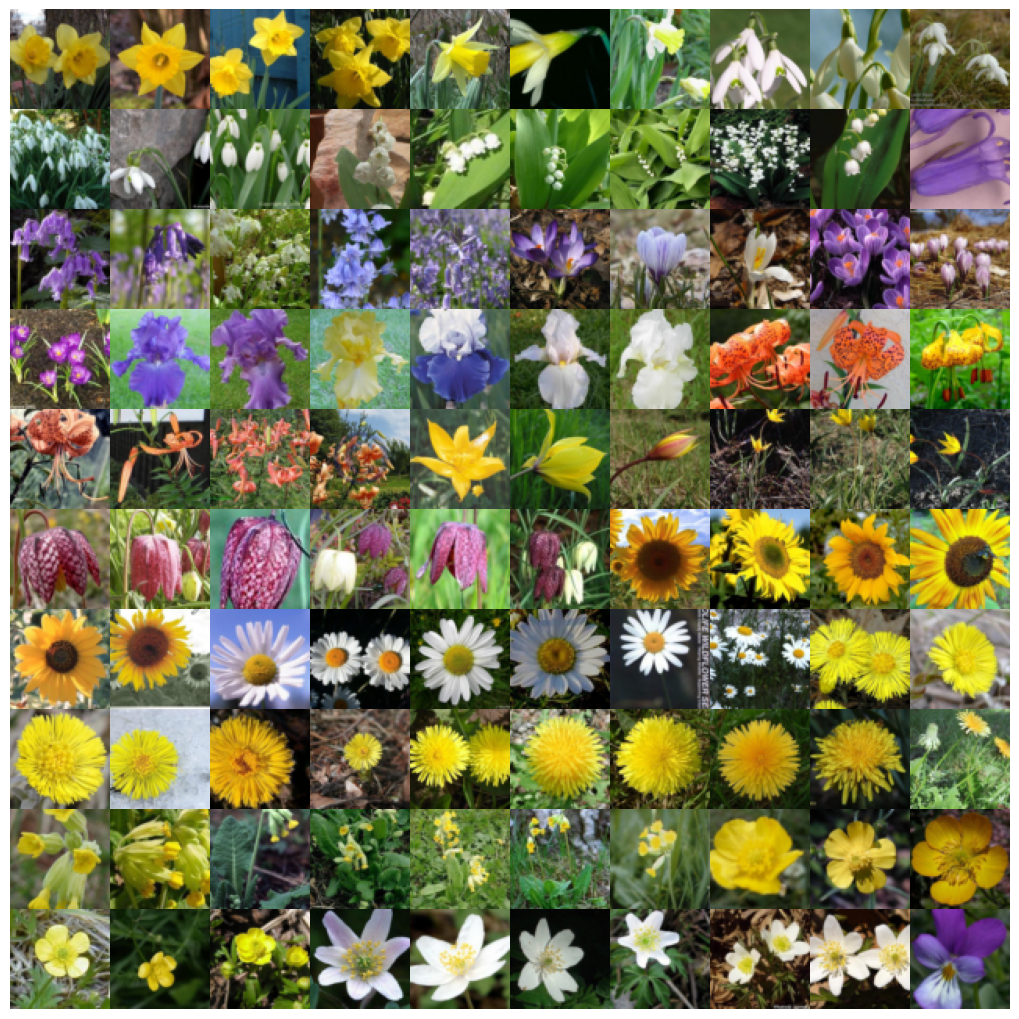

In [16]:

def crop_center_square(image_path, size_resized):
    """
    剪裁图像为方形
    """
    image = Image.open(image_path)
    width, height = image.size
    min_dim = min(width, height)
    
    crop_transform = transforms.Compose([
        transforms.CenterCrop(min_dim),
        transforms.Resize(size_resized),
    ])
    
    crop_image = crop_transform(image)
    return crop_image

def resize_image(image, size_resized):
    """
    调整图像大小
    """
    resize_transform = transforms.Compose([
        transforms.Resize(size_resized),
    ])
    image = resize_transform(image)
    return image

# 文件结构：
# datas/Ch5-LDA_dataset_17flowers/17flowers/
# ├── image_001.jpg
# ├── image_002.jpg
# ├── ...
# └── image_1360.jpg # 共 1360 张图片
# 读取并可视化本地路径 datas/Ch5-LDA_dataset_17flowers/17flowers 下所有图片的数据集
    
# 读取本地路径下的所有图片，17 个类，每个类 80 张图片，共 1360 张图片
image_root = f'{get_root_path()}/datas/Ch5-LDA_dataset_17flowers/17flowers/'
image_name_list = os.listdir(image_root)
n_class = 17
n_samples = 80
n_display = 10 * 10
n_rows = n_cols = int(math.sqrt(n_display))

# 获取其中一个图像的大小作为统一的显示大小
fig_size = (10, 10)

# 显示图片的密集排布形式
flower_images = []
flower_labels = []
fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
image_name_display_list = image_name_list[::13][:n_display]
for i, image_name in enumerate(image_name_list):
    image_path = os.path.join(image_root, image_name)
    image = crop_center_square(image_path, size_resized=64)
    
    # 存储图像和标签
    flower_images.append(image)
    flower_labels.append(i // n_class)
    
for i, image_name in enumerate(image_name_display_list):
    image_path = os.path.join(image_root, image_name)
    image = crop_center_square(image_path, size_resized=64)
    
    # 显示原始图像
    axes[i // n_cols][i % n_cols].imshow(image)
    axes[i // n_cols][i % n_cols].axis('off')
    
plt.show()

In [17]:
# 计算 17flowers 各类分类器的性能
X = np.array(flower_images).reshape(len(flower_images), -1)
y = np.array(flower_labels)
evaluate_classifier(X, y)

KNN: ACC=0.348, ARI=0.123, NMI=0.516
GaussianNB: ACC=0.527, ARI=0.265, NMI=0.642
MultinomialNB: ACC=0.451, ARI=0.202, NMI=0.592
BernoulliNB: ACC=0.151, ARI=0.001, NMI=0.243
ComplementNB: ACC=0.199, ARI=0.045, NMI=0.403


# 今日任务II：垃圾邮件过滤器(可选)

# 今日任务II：垃圾邮件过滤器(可选)